<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Javier González</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [ ]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


In [114]:
import h5py

large_data_filenames = {'GW150914': 'GWOSC_16KHZ_R1-1126259447-32.hdf5'}
fn_H1 = 'H-H1_' + large_data_filenames['GW150914']
fn_L1 = 'L-L1_' + large_data_filenames['GW150914']

# Se obtiene la frecuencia de muestreo de H1
with h5py.File(fn_H1, 'r') as hdf_file:
    # Verificar si la clave 'strain/Strain' existe en el archivo HDF5
    if 'strain/Strain' in hdf_file:
        datos = hdf_file['strain/Strain'][:]
        dt = hdf_file['strain/Strain'].attrs['Xspacing']
    else:
        raise KeyError("La clave 'strain/Strain' no existe en el archivo HDF5.")

fs = int(1.0 / dt)
print("Se tiene un sample rate de {0} Hz en: {1}".format(fs, fn_H1))


Se tiene un sample rate de 16384 Hz en: H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5


## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

In [109]:
from scipy.io import wavfile
import numpy as np

# Normalización de los datos
datos = datos - np.mean(datos)
datos = datos / np.max(np.abs(datos))

# Escalar los datos para que se ajusten al rango de un archivo WAV
strain_H1_scaled = np.int16(datos / np.max(np.abs(datos)) * 32767)

# Guardar los datos como archivo WAV
wavfile.write("GW150914_H1_audio.wav", fs, strain_H1_scaled)
print("Se ha guardado el archivo de audio como GW150914_H1_audio.wav")

Se ha guardado el archivo de audio como GW150914_H1_audio.wav


## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


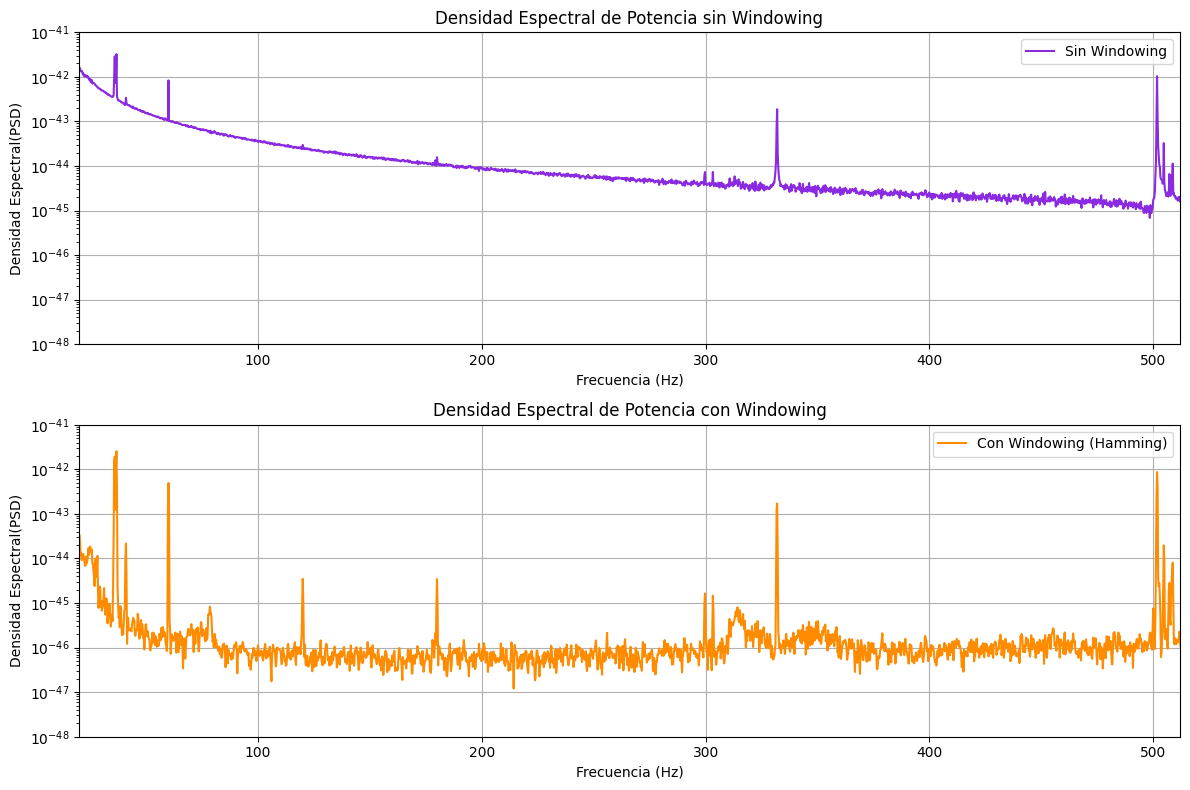

In [144]:
from scipy.signal.windows import hann
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import readligo as rl

# Se extraen los datos del archivo
datos, tiempo, dict = rl.loaddata(fn_H1)    
 
# Se setea el numero de muestras para la FFT
muestras = int(4 * fs)

# Se selecciona la funcion Hann para realizar el windowing
windowing = hann(muestras)

# Se hace la FFT para la señal sin windowing
densidad_espectral, frecuencia = mlab.psd(datos, Fs=fs, NFFT=muestras, window=mlab.window_none)
# Se hace la FFT para la señal con windowing
densidad_espectral_window, frecuencia_window = mlab.psd(datos, Fs=fs, NFFT=muestras, window=windowing)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.semilogy(frecuencia, densidad_espectral, color='blueviolet', label='Sin Windowing')
plt.title('Densidad Espectral de Potencia sin Windowing')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad Espectral(PSD)') 
plt.axis([20, 512, 1e-48, 1e-41])
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogy(frecuencia_window, densidad_espectral_window, color='darkorange', label='Con Windowing (Hamming)')
plt.title('Densidad Espectral de Potencia con Windowing')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad Espectral(PSD)') 
plt.axis([20, 512, 1e-48, 1e-41])
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


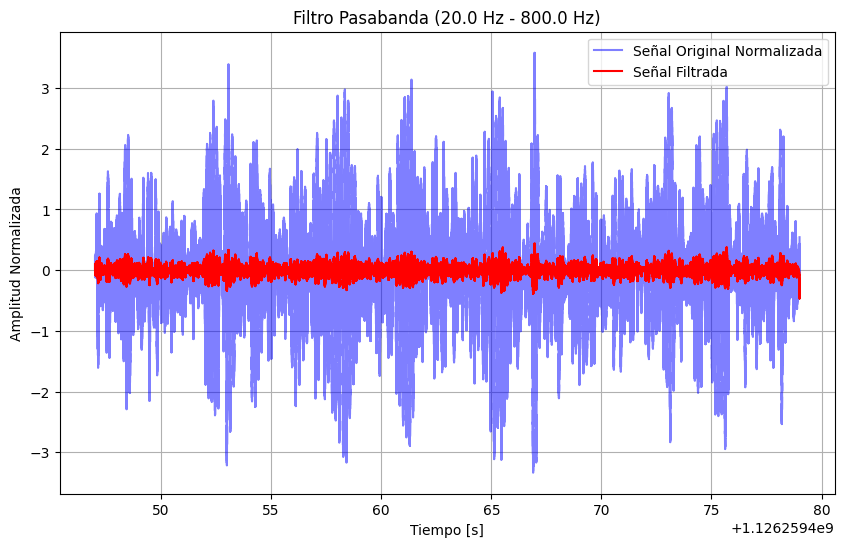

In [143]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Definir las frecuencias de corte del filtro pasabanda
f_low = 20.0  # Frecuencia de corte inferior en Hz
f_high = 800.0  # Frecuencia de corte superior en Hz

# Calcular las frecuencias normalizadas
nyquist_freq = 0.5 * fs  # Frecuencia de Nyquist
low_cutoff = f_low / nyquist_freq
high_cutoff = f_high / nyquist_freq

# Orden del filtro
order = 1

# Diseñar el filtro Butterworth
b, a = butter(order, [low_cutoff, high_cutoff], btype='bandpass')

# Normalizar los datos
datos_mean = np.mean(datos)
datos_std = np.std(datos)
datos_norm = (datos - datos_mean) / datos_std

# Aplicar el filtro a la señal normalizada
filtered_signal = filtfilt(b, a, datos_norm)

# Graficar la señal original y la señal filtrada
plt.figure(figsize=(10, 6))
plt.plot(tiempo, datos_norm, 'b', alpha=0.5, label='Señal Original Normalizada')
plt.plot(tiempo, filtered_signal, 'r', label='Señal Filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud Normalizada')
plt.title('Filtro Pasabanda ({} Hz - {} Hz)'.format(f_low, f_high))
plt.legend()
plt.grid(True)
plt.show()


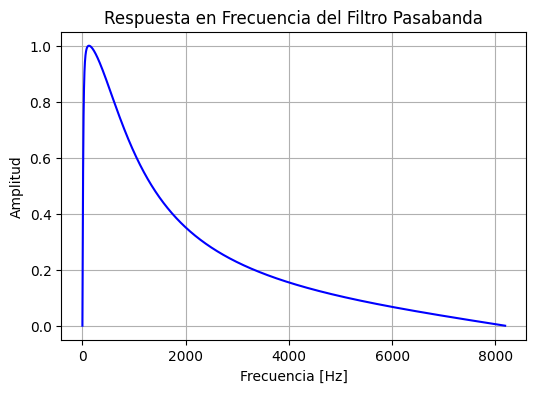

In [151]:
from scipy.signal import freqz

# Calcular la respuesta en frecuencia del filtro
w, h = freqz(b, a, worN=8000)

# Graficar la respuesta en frecuencia
plt.figure(figsize=(6, 4))
plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.title('Respuesta en Frecuencia del Filtro Pasabanda')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

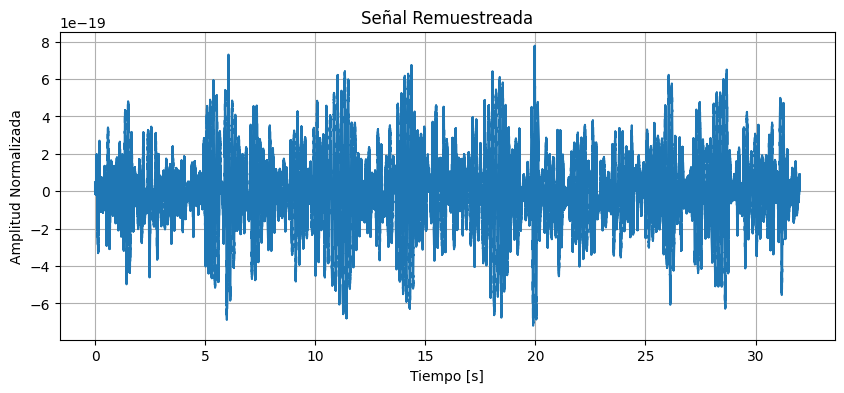

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

# Suponiendo que tienes una señal 'señal' y has realizado el resampling almacenando el resultado en 'señal_remuestreada'
nueva_fs = fs/3

# Realizar el resampling de la señal original
señal_remuestreada = resample(datos, int(len(filtered_signal) * nueva_fs / fs))

# Calcular el tiempo para la señal remuestreada
tiempo_remuestreado = np.linspace(0, len(señal_remuestreada) / nueva_fs, len(señal_remuestreada))

# Graficar la señal remuestreada en función del tiempo
plt.figure(figsize=(10, 4))
plt.plot(tiempo_remuestreado, señal_remuestreada)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud Normalizada')
plt.title('Señal Remuestreada')
plt.grid(True)
plt.show()

